In [17]:
from __future__ import print_function
from __future__ import division
from sshtunnel import SSHTunnelForwarder
import sys
import os
import configparser
import pandas as pd

working_path = os.path.abspath(os.path.join('.'))
if working_path.endswith('information-fostering'):
    working_path += '/notebooks'
sys.path.insert(1, working_path+'/../src/data')


# print(working_path)cd 

import dbconnect
import seaborn as sns
import matplotlib.pyplot as plt


ini_path = working_path+'/../config.ini'
# dir_path = os.path.dirname(os.path.realpath(__file__))
#config_path = dir_path+'/../../config.ini'
config = configparser.ConfigParser()
config.read(ini_path)
(server,mysql_connection) = dbconnect.connect_with_config(ini_path)



def parse_problemhelp_entry(text):
    import re
    matches=re.findall(r'\"(.+?)\"',text)
    return(matches)

valid_userids = [int(u) for u in config['STUDY']['userids_valid'].split(',')]
task_ids = [0,1,2]
stages_progress_df = pd.read_sql('''SELECT * FROM stages_progress''',mysql_connection)
problemhelp_df = pd.read_sql('''SELECT * FROM questionnaire_help_and_barriers''',mysql_connection)
problems = list(set([problem for (n,row) in problemhelp_df.iterrows() for problem in parse_problemhelp_entry(row['barriers'])]))
helps= list(set([help for (n,row) in problemhelp_df.iterrows() for help in parse_problemhelp_entry(row['help'])]))
stageid_to_task = {3:1,15:2,19:3}


print(valid_userids)
print(problems)
print(helps)

for p in problems:
    problemhelp_df[p] = problemhelp_df['barriers'].map(lambda x: p in parse_problemhelp_entry(x))
for h in helps:
    problemhelp_df[h] = problemhelp_df['help'].map(lambda x: h in parse_problemhelp_entry(x))
    
    
problems_unpacked_df = []
for (n,row) in problemhelp_df.iterrows():
    for p in problems:
        if row[p]:
            newrow = dict()
            for elem in problemhelp_df.columns.values:
                if (elem not in problems) and (elem not in helps):
                    newrow[elem] = row[elem]
            newrow['problem'] = p
            problems_unpacked_df += [newrow]
  
helps_unpacked_df = []          
for (n,row) in problemhelp_df.iterrows():
    for h in helps:
        if row[h]:
            newrow = dict()
            for elem in problemhelp_df.columns.values:
                if (elem not in problems) and (elem not in helps):
                    newrow[elem] = row[elem]
            newrow['help_single'] = h
            helps_unpacked_df += [newrow]

problems_unpacked_df = pd.DataFrame(problems_unpacked_df)
helps_unpacked_df = pd.DataFrame(helps_unpacked_df)

problems_unpacked_df = problems_unpacked_df[problems_unpacked_df['user_id'].isin(valid_userids)]
helps_unpacked_df = helps_unpacked_df[helps_unpacked_df['user_id'].isin(valid_userids)]
problemhelp_df = problemhelp_df[problemhelp_df['user_id'].isin(valid_userids)]
stages_progress_df = stages_progress_df[stages_progress_df['user_id'].isin(valid_userids)]

pretask_stage_to_taskid = {2:0,6:1,17:2}
task_stage_to_taskid = {3:0,15:1,19:2}
posttask_stage_to_taskid = {4:0,16:1,20:2}

problems_unpacked_df['task_id'] =  problems_unpacked_df['stage_id'].map(task_stage_to_taskid)
helps_unpacked_df['task_id'] =  helps_unpacked_df['stage_id'].map(task_stage_to_taskid)
problemhelp_df['task_id'] =  problemhelp_df['stage_id'].map(task_stage_to_taskid)

problems_unpacked_df.to_csv('/Users/Matt/Desktop/problems_unpacked.csv')
helps_unpacked_df.to_csv('/Users/Matt/Desktop/helps_unpacked.csv')
problemhelp_df.to_csv('/Users/Matt/Desktop/problemhelp.csv')





server.stop()

[37, 49, 59, 70, 94, 97, 101, 110, 112, 113, 116, 118, 119, 123, 125, 126, 127]
['sources_unaware', 'patience_lack', 'credibility_uncertain', 'source_unavailable', 'no_problem', 'difficult_articulate', 'toomuch_information', 'irrelevant_results', 'topknowledge_lack']
['page_recommendation', 'strategy_recommendation', 'no_help_needed', 'system_unsatisfactory', 'query_recommendation', 'people_recommendation']


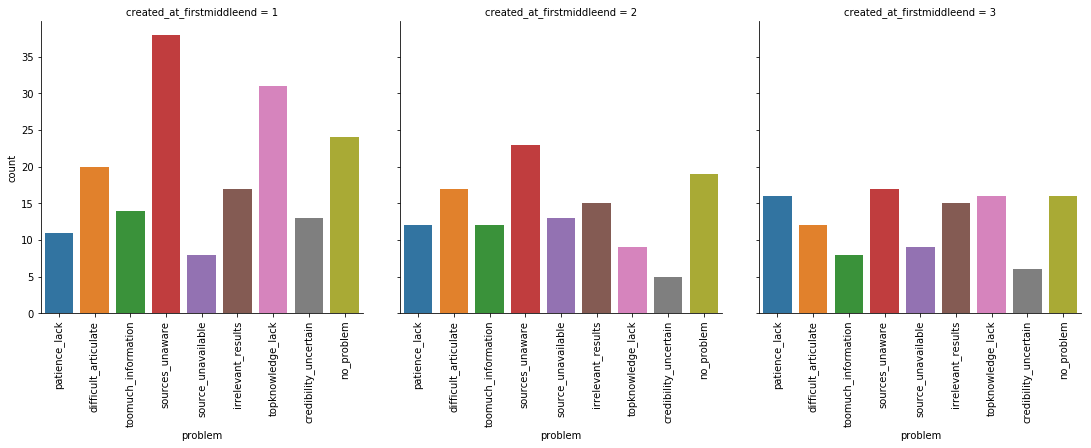

<Figure size 432x288 with 0 Axes>

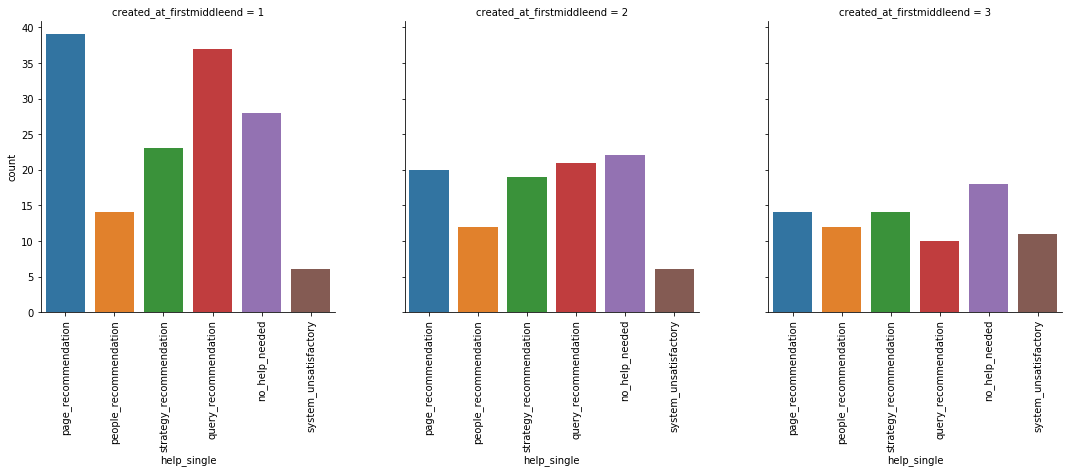

<Figure size 432x288 with 0 Axes>

In [35]:
# RQ1 - To what extent do the problems experienced and help required by users change 
# throughout a user’s search session?

taskid_to_task_posttask_stageids =   {0:(3,4),1:(15,16),2:(19,20)}

#map: (userid,taskid) to (first,middle,end)

userid_taskid_to_firstmiddleend_ts = dict()
problems_unpacked_firstmiddleend_df = []
helps_unpacked_firstmiddleend_df = []
for u in valid_userids:
    for t in [0,1,2]:
        (task_stageid,posttask_stageid) = taskid_to_task_posttask_stageids[t]
        user_progress_df = stage_progress_df[(stage_progress_df['stage_id'].isin([task_stageid,posttask_stageid])) & (stage_progress_df['user_id']==u)]
        user_progress_df = user_progress_df.sort_values(by=['stage_id'])
        start_time = user_progress_df['created_at'].tolist()[0]
        end_time = user_progress_df['created_at'].tolist()[-1]
#         print(start_time)

#         print(type(start_time))
#         print(type(end_time-start_time))
        assert end_time > start_time
        one_third_elapsedtime = (end_time-start_time)/3.0
        user_problems_bytask_df = problems_unpacked_df[(problems_unpacked_df['user_id']==u) & (problems_unpacked_df['task_id']==t)]
        user_helps_bytask_df = helps_unpacked_df[(helps_unpacked_df['user_id']==u) & (helps_unpacked_df['task_id']==t)]
        user_problems_bytask_df['created_at_firstmiddleend'] = user_problems_bytask_df['created_at'].apply(lambda x: (x-start_time)//one_third_elapsedtime+1)
        user_helps_bytask_df['created_at_firstmiddleend'] = user_helps_bytask_df['created_at'].apply(lambda x: (x-start_time)//one_third_elapsedtime+1)
        problems_unpacked_firstmiddleend_df += [user_problems_bytask_df]
        helps_unpacked_firstmiddleend_df += [user_helps_bytask_df]
        
problems_unpacked_firstmiddleend_df = pd.concat(problems_unpacked_firstmiddleend_df)
helps_unpacked_firstmiddleend_df = pd.concat(helps_unpacked_firstmiddleend_df)
        
problems_unpacked_firstmiddleend_df.to_csv('/Users/Matt/Desktop/problems_unpacked_firstmiddleend_df.csv')
helps_unpacked_firstmiddleend_df.to_csv('/Users/Matt/Desktop/helps_unpacked_firstmiddleend_df.csv')


g = sns.catplot("problem", col="created_at_firstmiddleend", col_wrap=5, 
                data=problems_unpacked_firstmiddleend_df,
                kind="count") #, height=2.5, aspect=.8)
g.set_xticklabels(rotation=90)
plt.show()
plt.clf()



g = sns.catplot("help_single", col="created_at_firstmiddleend", col_wrap=5, 
                data=helps_unpacked_firstmiddleend_df,
                kind="count") #, height=2.5, aspect=.8)
g.set_xticklabels(rotation=90)
plt.show()
plt.clf()

In [3]:
# RQ 2 - Do behaviors differ as the problems experienced by users differ? 
# As the help required by users differs?


# Behaviors, query length, n pages

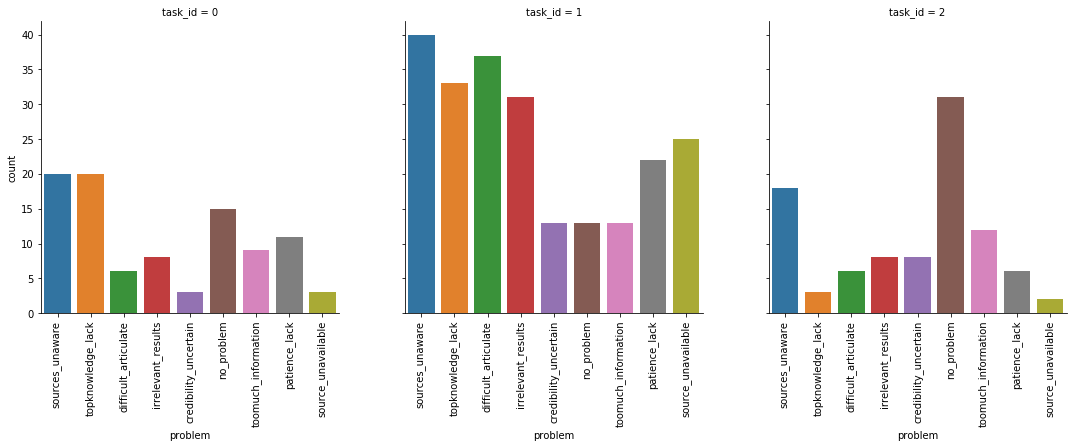

<Figure size 432x288 with 0 Axes>

In [8]:
# RQ 3.1 - Do the problems experienced by users differ between tasks?

g = sns.catplot("problem", col="task_id", col_wrap=5, 
                data=problems_unpacked_df,
                kind="count") #, height=2.5, aspect=.8)
g.set_xticklabels(rotation=90)
plt.show()
plt.clf()


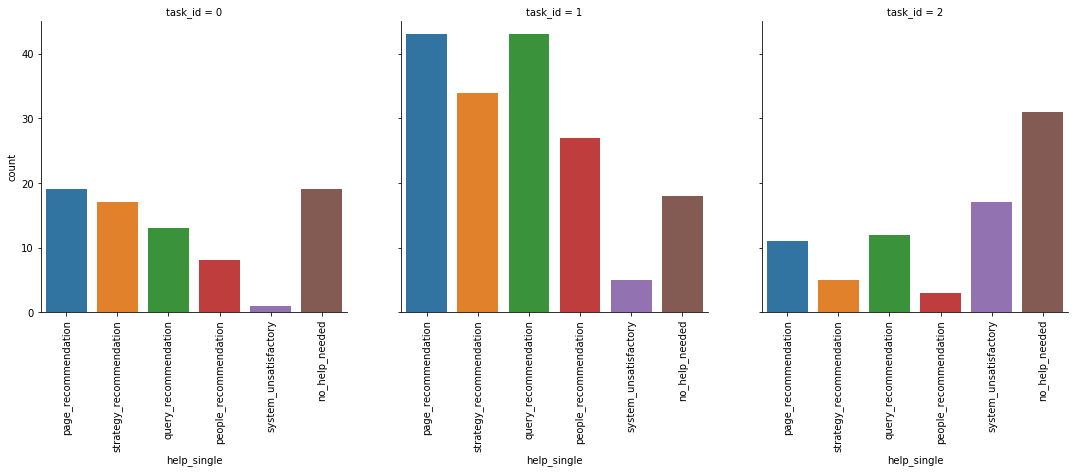

<Figure size 432x288 with 0 Axes>

In [36]:
# RQ 3.2 - Do the helps required by users differ between tasks?

g = sns.catplot("help_single", col="task_id", col_wrap=5, 
                data=helps_unpacked_df,
                kind="count") #, height=2.5, aspect=.8)
g.set_xticklabels(rotation=90)
plt.show()
plt.clf()


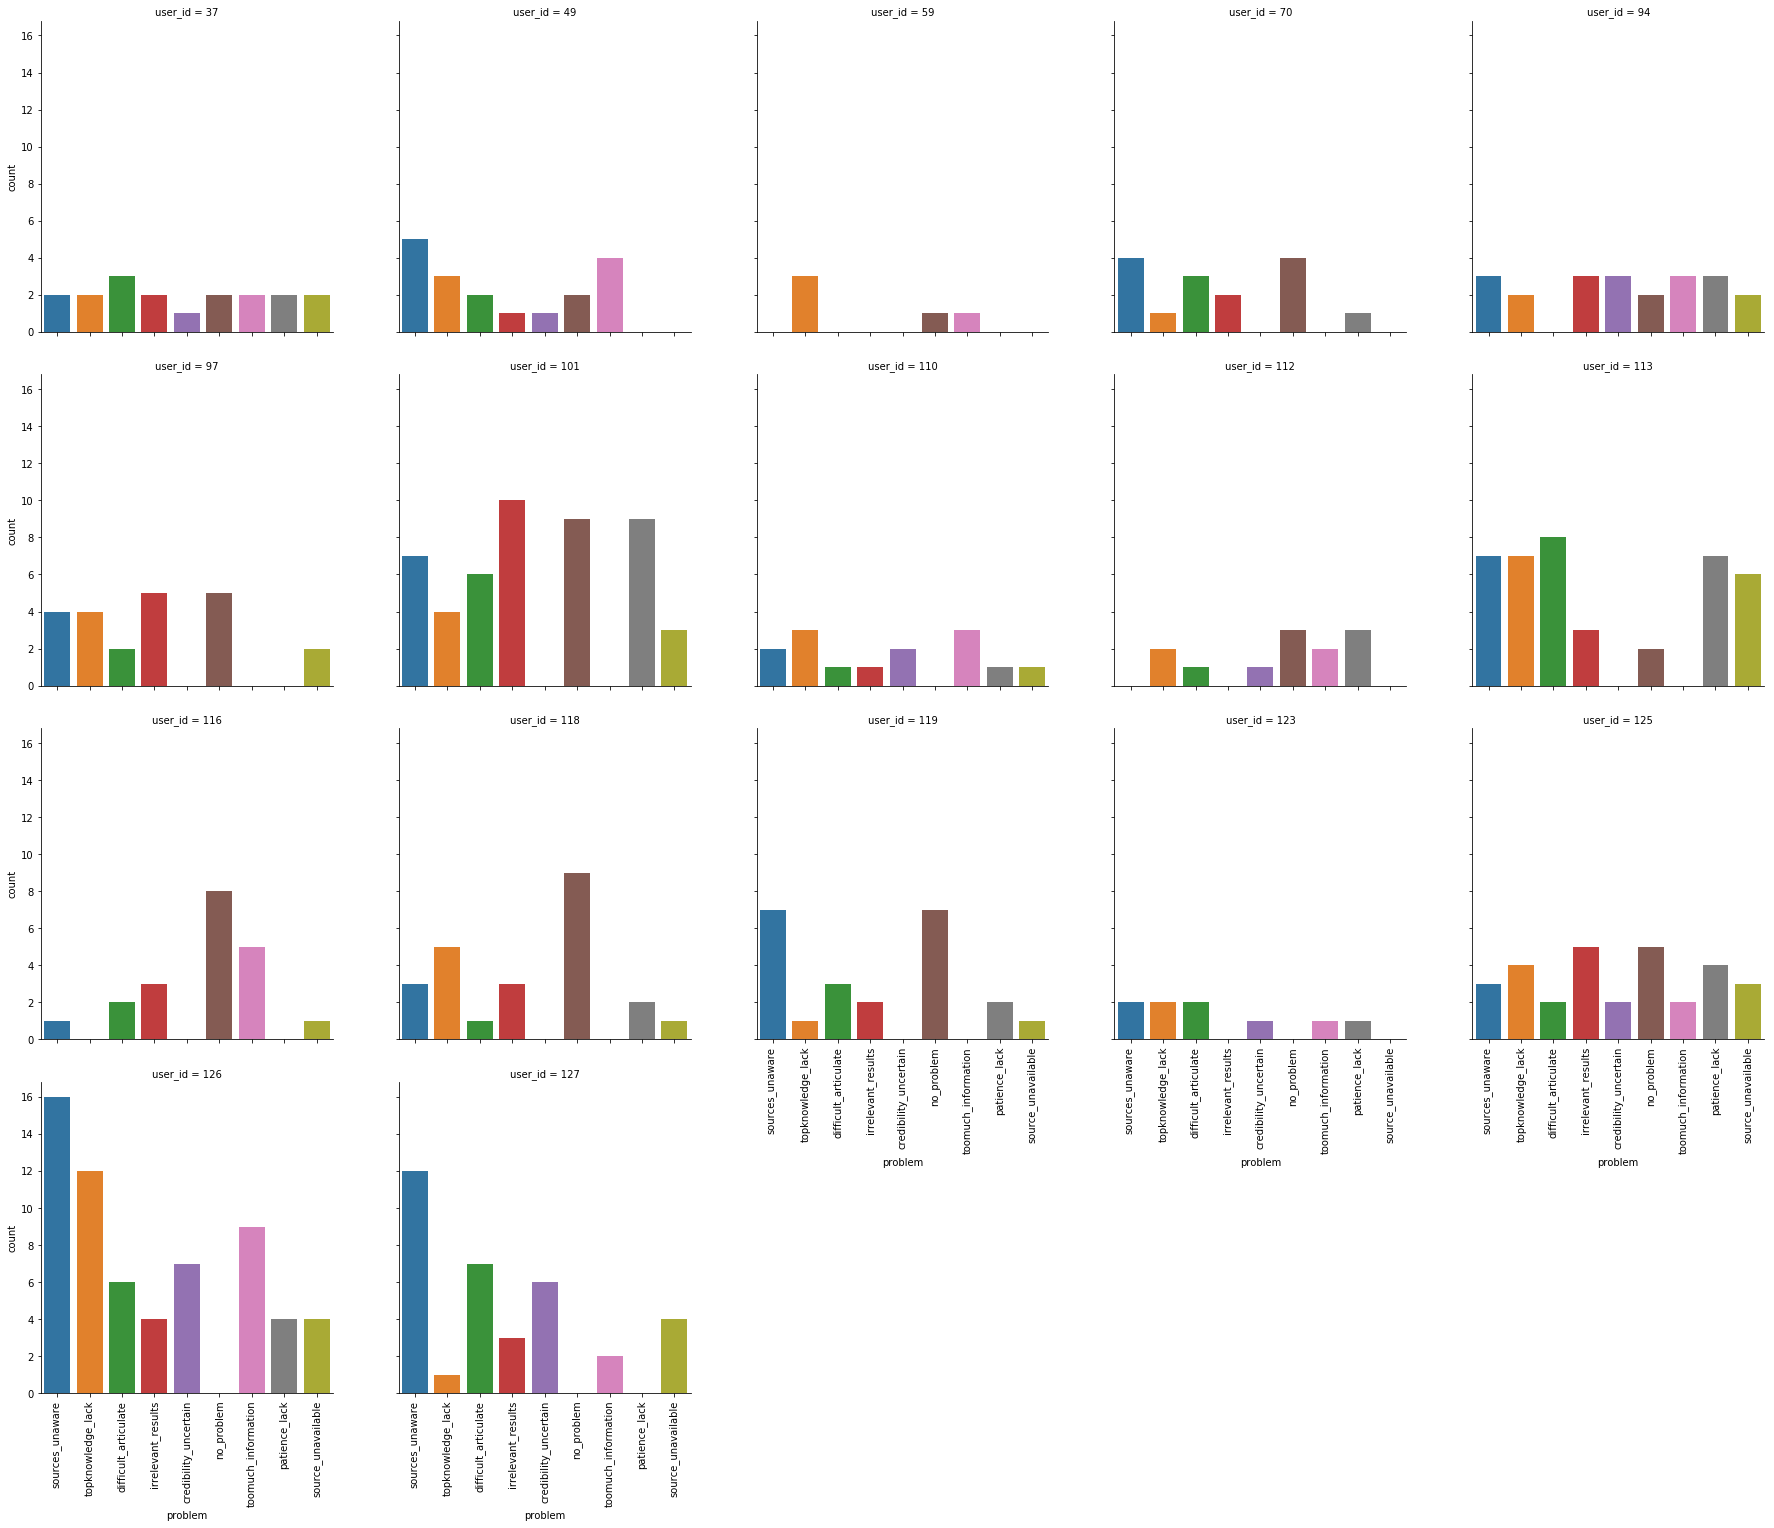

<Figure size 432x288 with 0 Axes>

In [10]:
# RQ 4.1 - Do the problems experienced by users differ between users?

g = sns.catplot("problem", col="user_id", col_wrap=5, 
                data=problems_unpacked_df,
                kind="count") #, height=2.5, aspect=.8)
g.set_xticklabels(rotation=90)
plt.show()
plt.clf()
#g = sns.FacetGrid(problemhelp_df, col="user_id", col_wrap=6)
#g = g.map(plt.plot, "solutions", "score", marker=".")

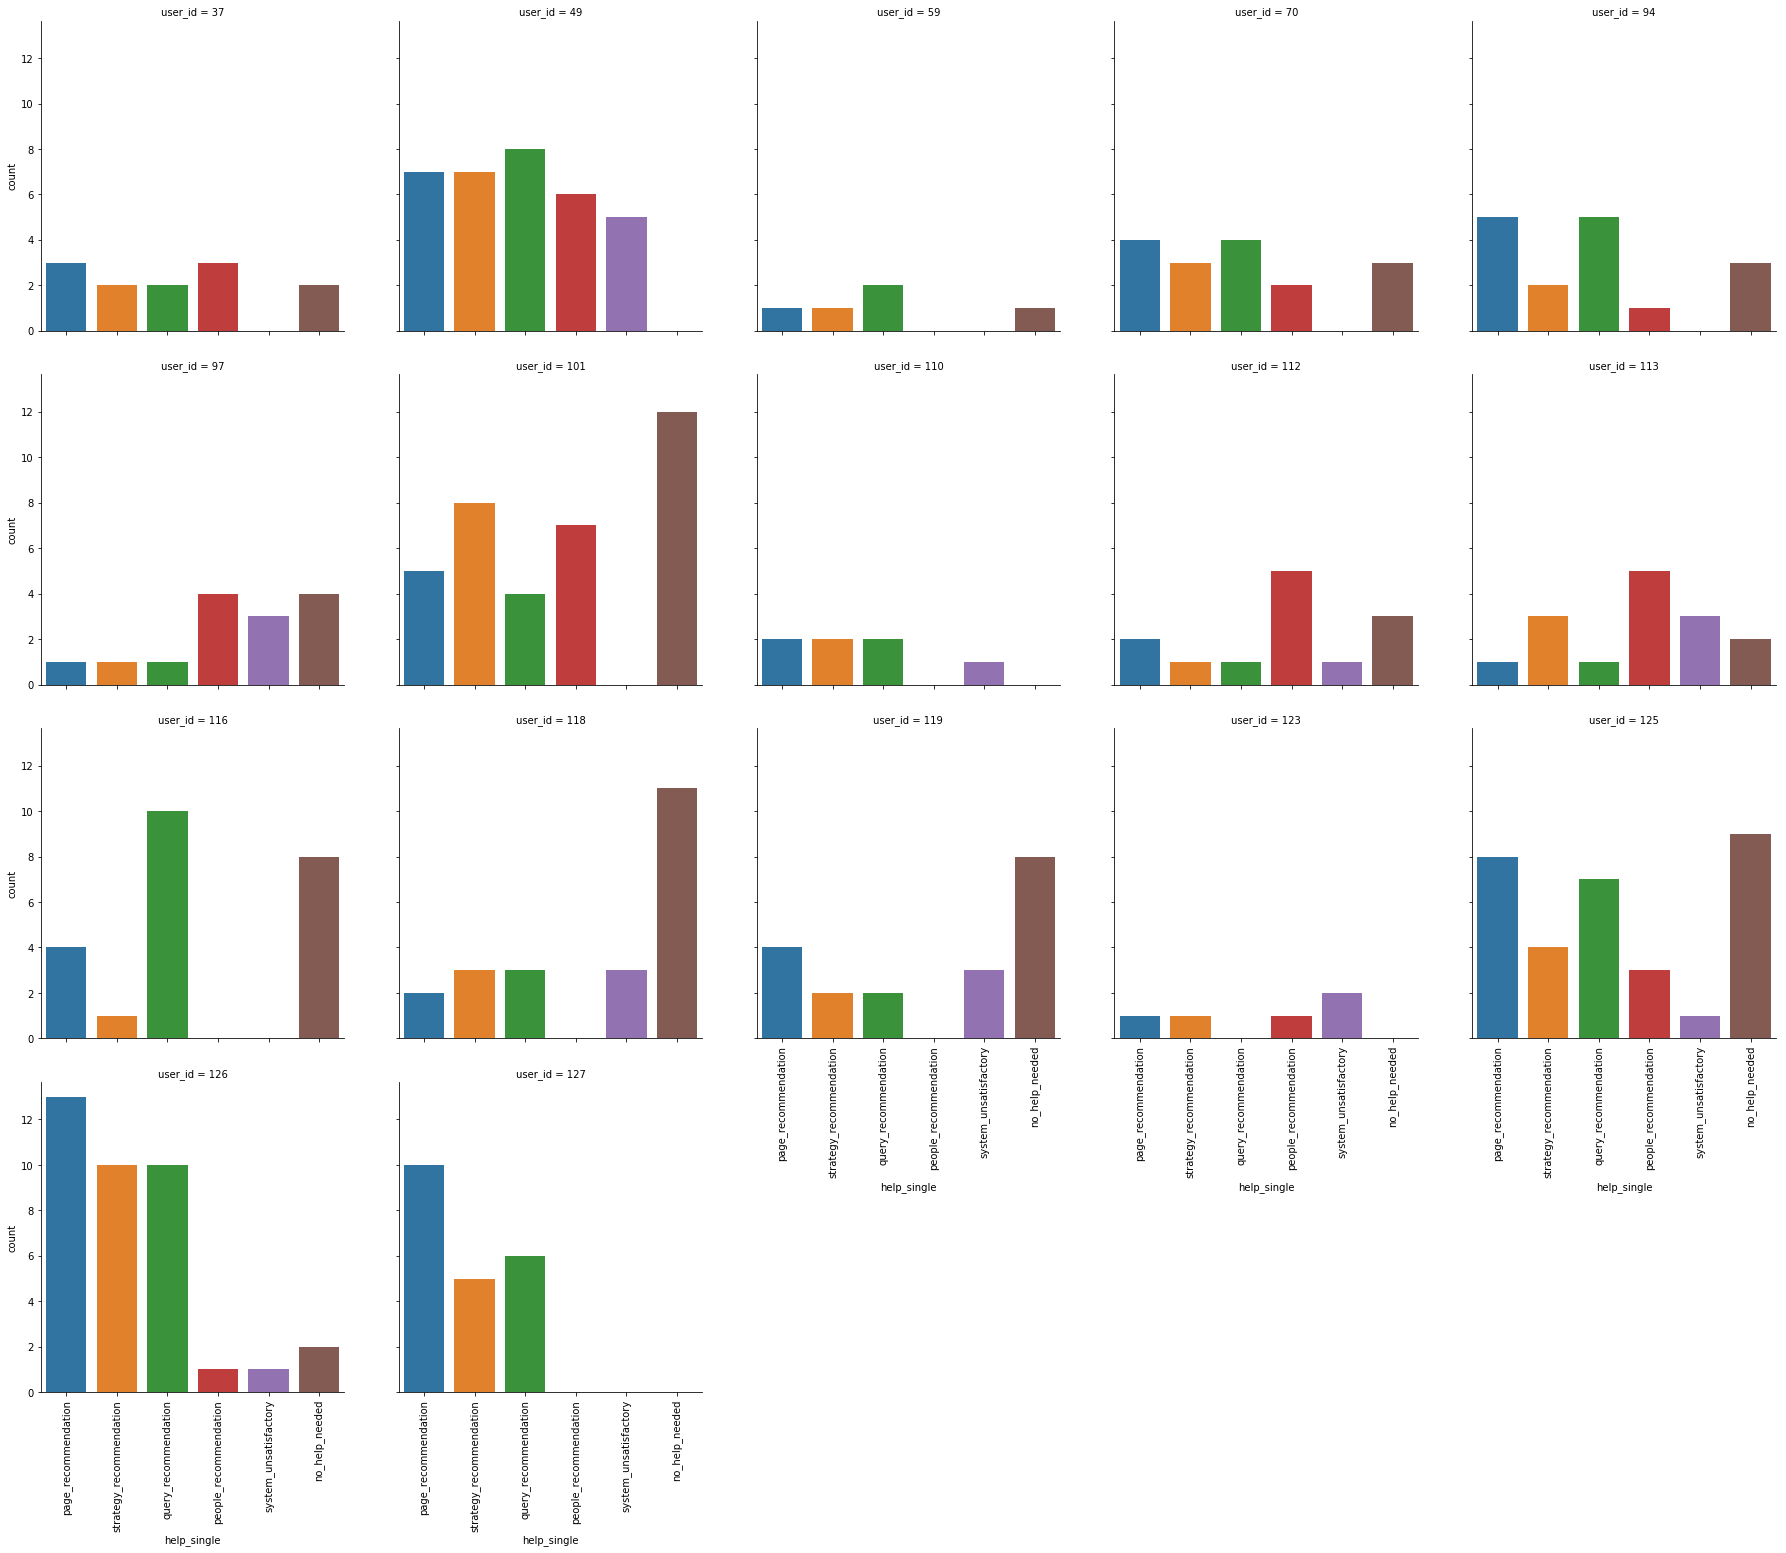

<Figure size 432x288 with 0 Axes>

In [11]:
# RQ 4.2 - Do the helps required by users differ between users?

g = sns.catplot("help_single", col="user_id", col_wrap=5, 
                data=helps_unpacked_df,
                kind="count") #, height=2.5, aspect=.8)
g.set_xticklabels(rotation=90)
plt.show()
plt.clf()
#g = sns.FacetGrid(problemhelp_df, col="user_id", col_wrap=6)
#g = g.map(plt.plot, "solutions", "score", marker=".")

In [ ]:
# RQ 5 - Do the problems experienced/help required by users differ between 
# user types (e.g., hi/lo topic familiarity)?

In [ ]:
# RQ 6 - To what extent do behaviors, problems experienced by users, and required help affect 
# users’ expectation disconfirmation?


# RQ 6.1 - To what extent are user behaviors, problems experienced by users, and required help 
# associated with their expectation disconfirmation states?

# RQ 6.2 - To what extent can we predict users’ expectation disconfirmation states from Web 
# search behavior?

In [11]:
# RQ 7 - What is the nature of the relationship between user characteristics, task characteristics, 
# behaviors, and the problems experienced by users?


In [ ]:
# RQ8 - To what extent can we predict the problems/help experienced by users at a given moment, 
# given our answers to RQ1-7?